In [1]:
import os
import time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scipy.optimize
import itertools
import math

import hoomd
import gsd.hoomd
import coxeter

import freud

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
lattice = gsd.hoomd.open('./DATA/lattice.gsd')
octa_verts = lattice[0].particles.type_shapes[0]['vertices']
octa = coxeter.shapes.ConvexPolyhedron(octa_verts)

In [3]:
traj = gsd.hoomd.open('./DATA/anneal.gsd', 'rb')
traj[-1].log

{'Simulation/timestep': array([100000]),
 'Simulation/walltime': array([46.550911]),
 'md/compute/ThermodynamicQuantities/kinetic_temperature': array([0.99140234]),
 'md/compute/ThermodynamicQuantities/pressure': array([0.07059117]),
 'md/compute/ThermodynamicQuantities/pressure_tensor': array([ 0.07514823,  0.0043806 , -0.00457103,  0.06496536, -0.0288714 ,
         0.07165991]),
 'md/compute/ThermodynamicQuantities/kinetic_energy': array([640.9416133]),
 'md/compute/ThermodynamicQuantities/translational_kinetic_energy': array([340.32306667]),
 'md/compute/ThermodynamicQuantities/rotational_kinetic_energy': array([300.61854663]),
 'md/compute/ThermodynamicQuantities/potential_energy': array([1.87757244]),
 'md/compute/ThermodynamicQuantities/degrees_of_freedom': array([1293.]),
 'md/compute/ThermodynamicQuantities/translational_degrees_of_freedom': array([645.]),
 'md/compute/ThermodynamicQuantities/rotational_degrees_of_freedom': array([648.]),
 'md/compute/ThermodynamicQuantities/nu

In [4]:
traj = gsd.hoomd.open('./DATA/trajectory.gsd', 'rb')
traj = traj[::10]

timestep = []
walltime = []
kT= []
pressure = []
pe = []
ke = []

for frame in traj:
    timestep.append(frame.configuration.step)
    walltime.append(frame.log['Simulation/walltime'][0])
    kT.append(frame.log['md/compute/ThermodynamicQuantities/kinetic_temperature'][0])
    pressure.append(frame.log['md/compute/ThermodynamicQuantities/pressure'][0])
    pe.append(frame.log['md/compute/ThermodynamicQuantities/potential_energy'][0])
    
kT = np.asarray(kT)
pressure = np.asarray(pressure)
pe = np.asarray(pe)

In [5]:
num = octa.volume*traj[0].particles.N

phi_arr = []

for frame in traj:

    phi = num/np.prod(frame.configuration.box[:3])
    phi_arr.append(phi)
    
phi_arr = np.asarray(phi_arr)

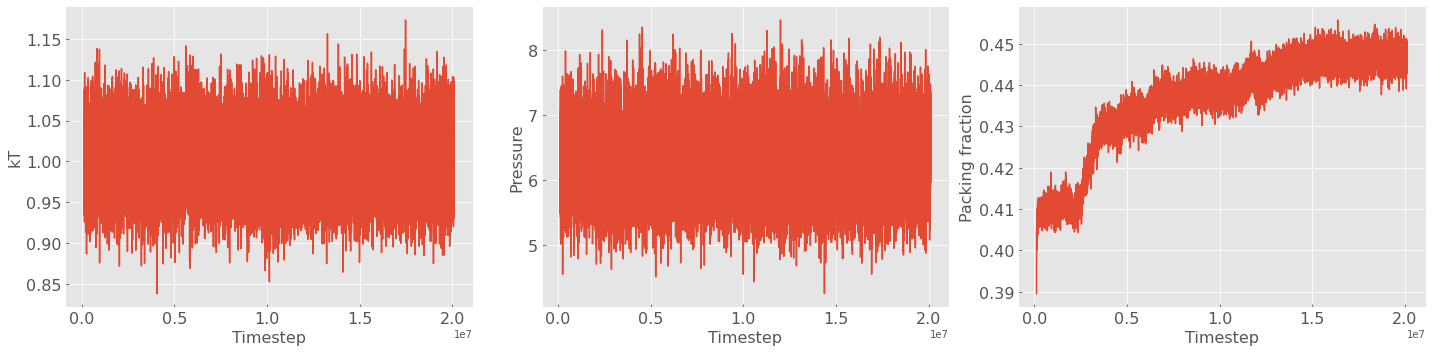

In [6]:
fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=3)

ax[0].plot(timestep, kT)
ax[0].tick_params(axis='both', which='both', direction='in', labelsize=16)
ax[0].set_xlabel('Timestep', size=16)
ax[0].set_ylabel('kT', size=16)

ax[1].plot(timestep, pressure)
ax[1].tick_params(axis='both', which='both', direction='in', labelsize=16)
ax[1].set_xlabel('Timestep', size=16)
ax[1].set_ylabel('Pressure', size=16)

ax[2].plot(timestep, phi_arr)
ax[2].tick_params(axis='both', which='both', direction='in', labelsize=16)
ax[2].set_xlabel('Timestep', size=16)
ax[2].set_ylabel('Packing fraction', size=16)

fig.tight_layout()
plt.show()

In [10]:
frame = traj[-1]

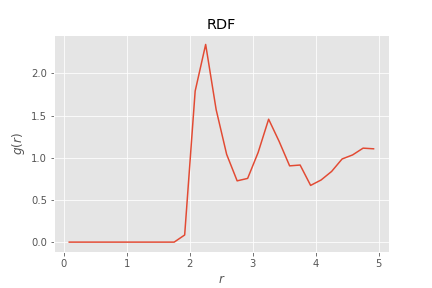

<Figure size 432x288 with 0 Axes>

In [11]:
rdf = freud.density.RDF(bins=30, r_max=5)

rdf.compute(system=frame)

In [7]:
qc = freud.order.Steinhardt(l=6, average=True)

qc_arr = []

for frame in traj:
    
    box = frame.configuration.box
    points = frame.particles.position
    
    system = freud.AABBQuery(box, points)
    args = {"num_neighbors": 6, "exclude_ii": True}
    nlist = system.query(points, args).toNeighborList()
    
    qc.compute(system, neighbors=nlist)
    qc_arr.append(qc.order)
    
qc_arr = np.asarray(qc_arr)

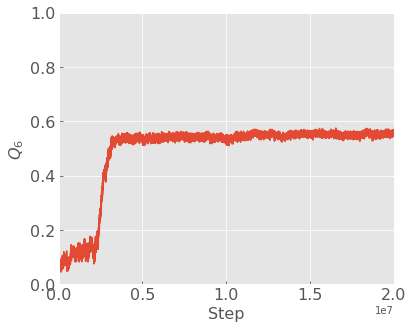

In [14]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(timestep, qc_arr)

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.set_xlabel('Step', size=16)
ax.set_ylabel('$Q_6$', size=16)
ax.set_xlim(0, 2e7)
ax.set_ylim(0, 1)

plt.show()

In [9]:
nop_arr = []

for frame in traj:
    
    nop = freud.order.Nematic([0,0,1])
    nop_val = nop.compute(frame.particles.orientation)
    nop_arr.append(nop_val.order)
    
nop_arr = np.asarray(nop_arr)

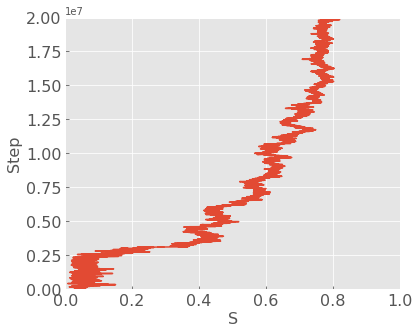

In [13]:
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(nop_arr, timestep)

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.set_xlabel('S', size=16)
ax.set_ylabel('Step', size=16)
ax.set_xlim(0, 1)
ax.set_ylim(0, 2e7)

plt.show()

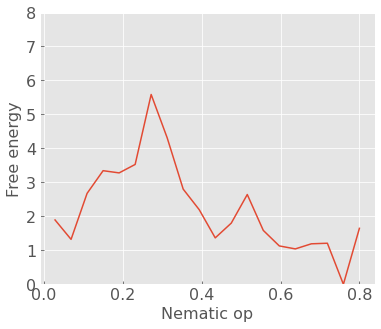

In [11]:
hist = np.histogram(nop_arr[:], bins=20)
prob = hist[0].T/np.sum(hist[0].T)
freeE = -np.log(prob+1e-11)
mids = 0.5*(hist[1][1:]+hist[1][:-1])

fig, ax = plt.subplots(figsize=(6,5))

ax.plot(mids, freeE-np.min(freeE))

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.set_xlabel('Nematic op', size=16)
ax.set_ylabel('Free energy', size=16)
ax.set_ylim(0,8)

plt.show()

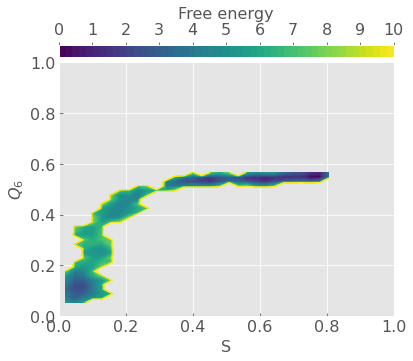

In [12]:
# data
hist = np.histogram2d(nop_arr, qc_arr, bins=30)
prob = hist[0].T/np.sum(hist[0].T)
freeE = -np.log(prob+1e-11)
mids_x, mids_y = 0.5*(hist[1][1:]+hist[1][:-1]), 0.5*(hist[2][1:]+hist[2][:-1])

levels = np.linspace(0., 10., 50)

# plot
fig, ax = plt.subplots(figsize=(6,5))

ctrp = ax.contourf(mids_x, mids_y, freeE-np.min(freeE), levels=levels)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='5%', pad='2%')
ticks=np.round(np.linspace(0., 12. , 13), 1)
cbr = fig.colorbar(ctrp, cax=cax, ticks=ticks, orientation='horizontal')
cax.set_xlabel('Free energy', size=16)
cax.xaxis.set_label_position('top') 
cax.xaxis.set_ticks_position('top')
cbr.ax.tick_params(labelsize=16)

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.set_xlabel('S', size=16)
ax.set_ylabel('$Q_{6}$', size=16)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.show()

In [15]:
import rowan
from mpl_toolkits.mplot3d import Axes3D

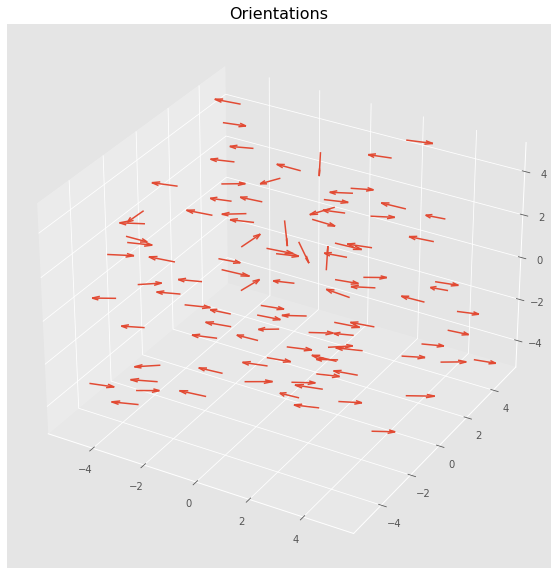

In [16]:
frame = traj[-1]
points = frame.particles.position[:100]
orientations = frame.particles.orientation[:100]

# To show orientations, we use arrows rotated by the quaternions.
arrowheads = rowan.rotate(orientations, [0,0,1])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
ax.quiver3D(points[:,0],
            points[:,1],
            points[:,2],
            arrowheads[:,0],
            arrowheads[:,1],
            arrowheads[:,2]
)
ax.set_title("Orientations", fontsize=16);

#### Diffraction pattern

In [72]:
dp = freud.diffraction.DiffractionPattern(grid_size=1024, output_size=1024)

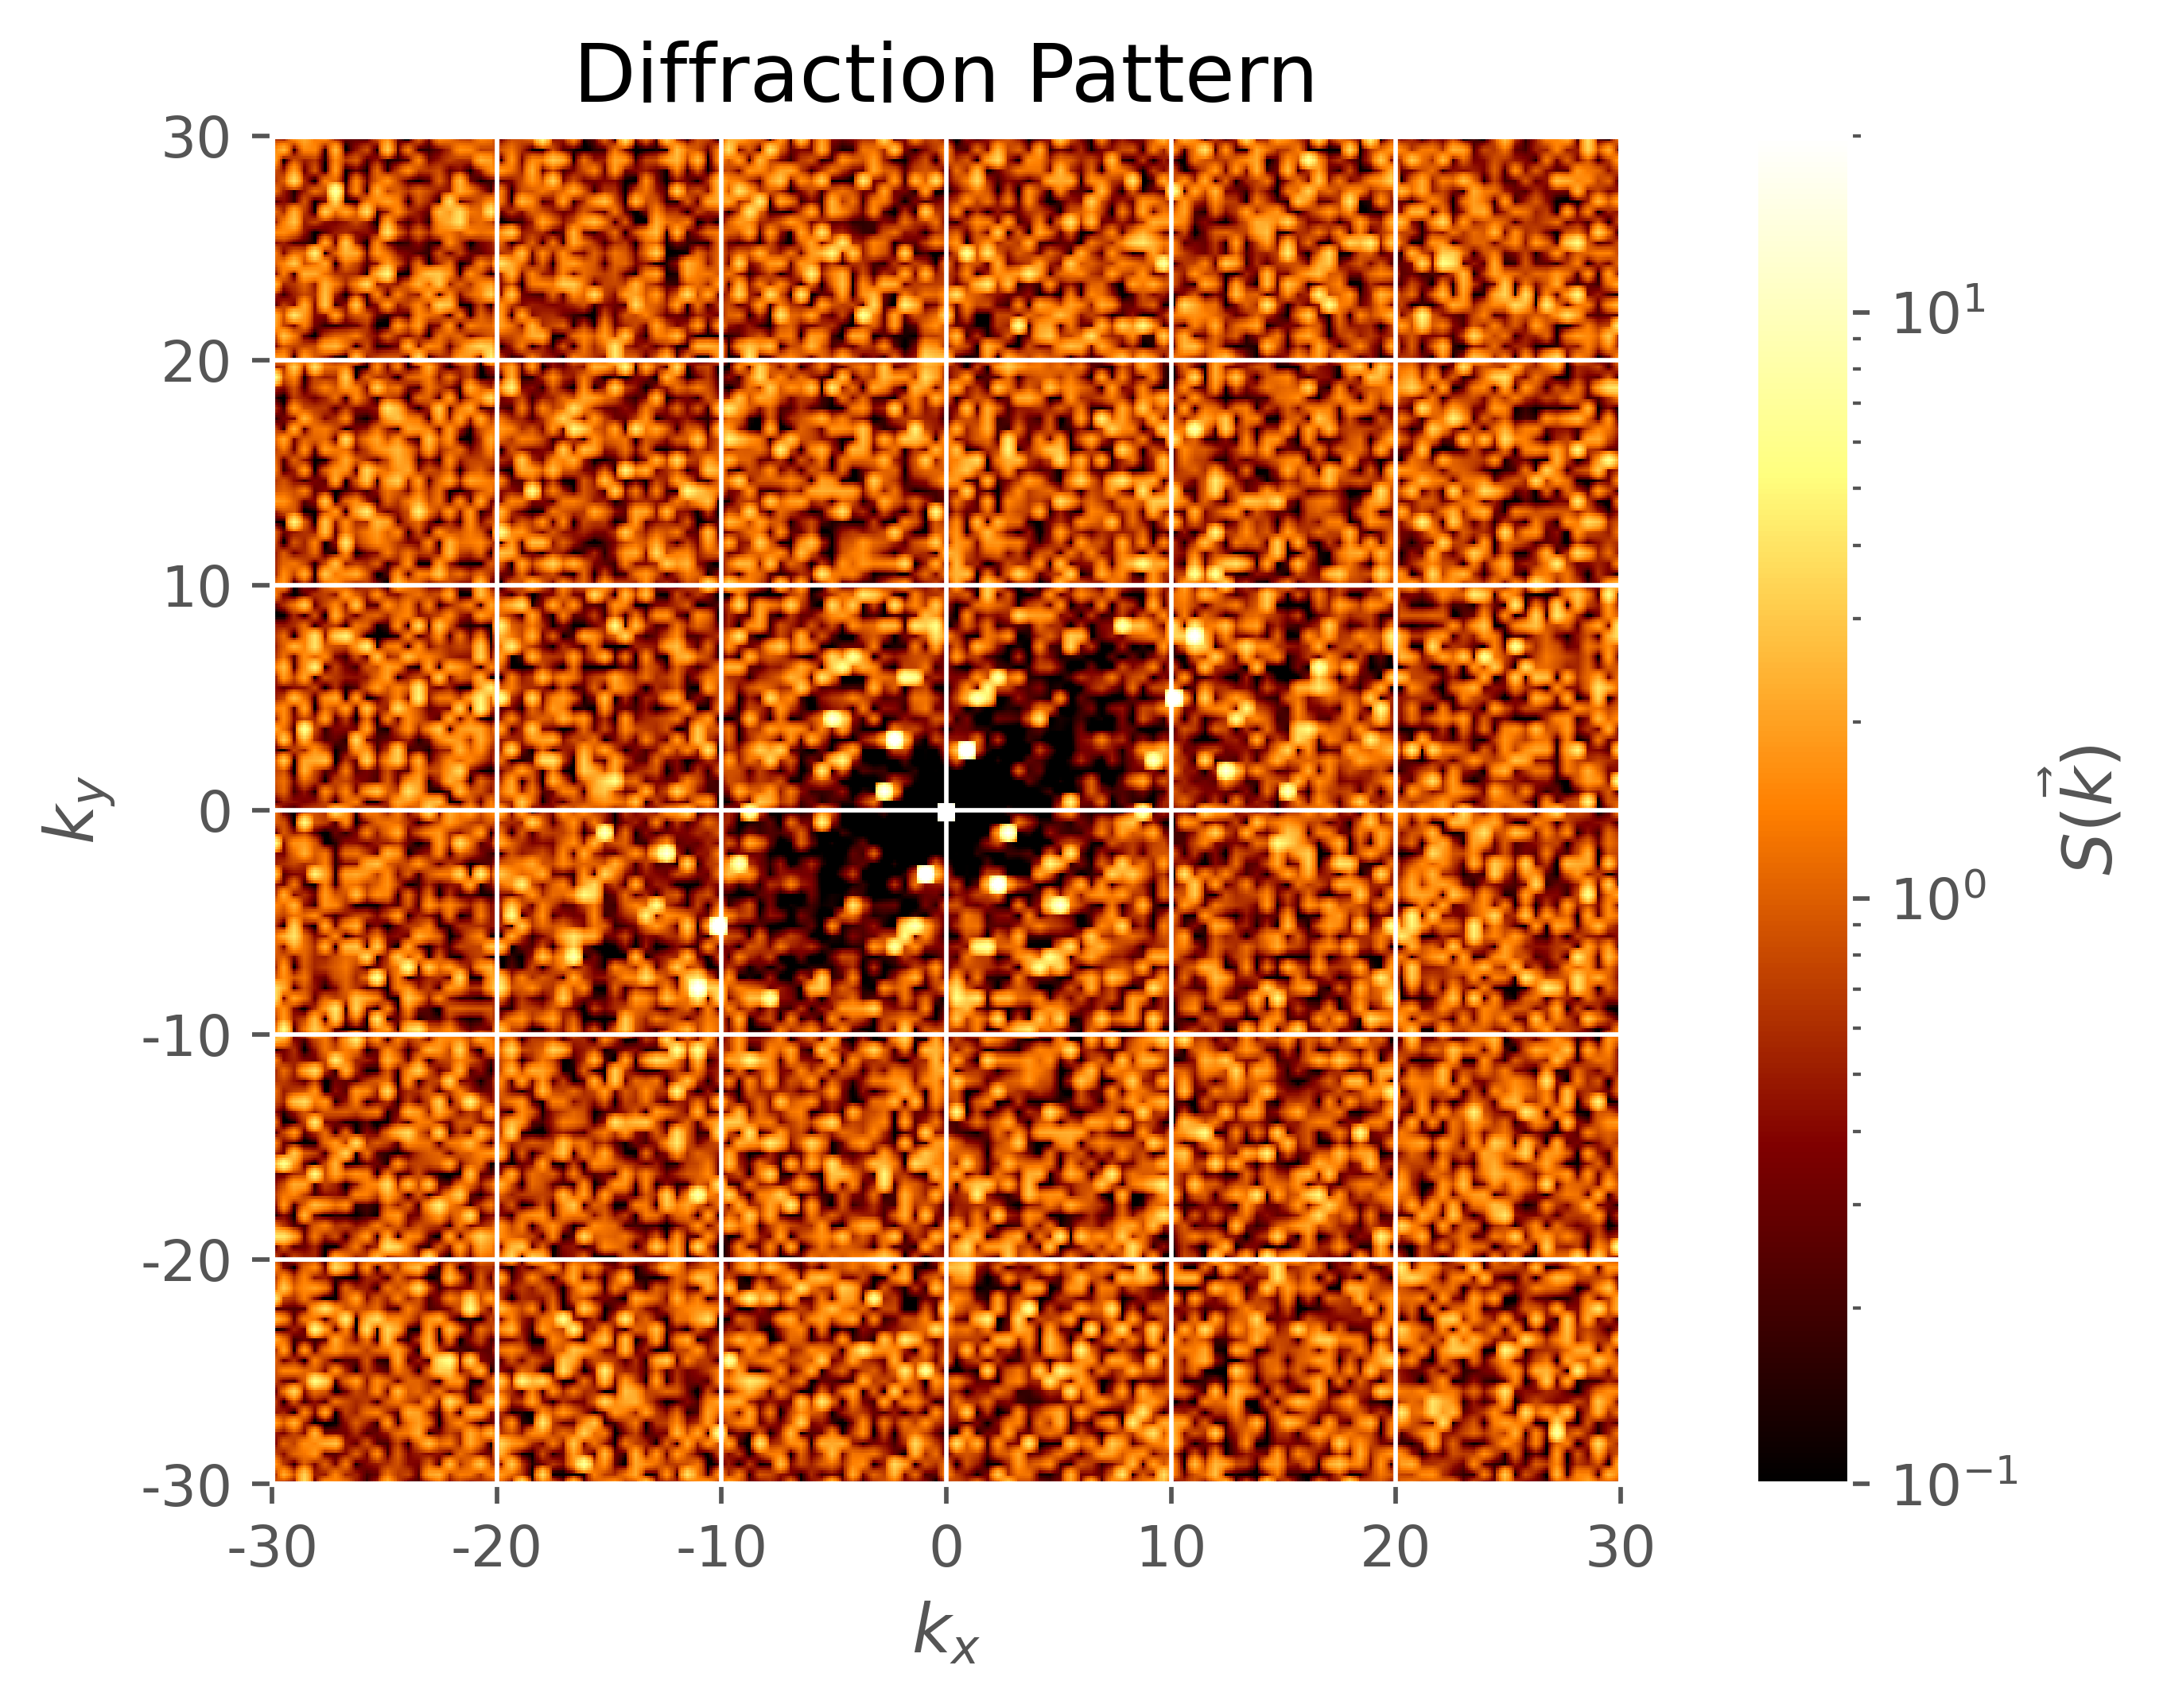

In [81]:
frame=traj[-1]

fig, ax = plt.subplots(figsize=(5,5), dpi=512)
dp.compute((frame.configuration.box,
            frame.particles.position),
            view_orientation=[1,0,0,0])
dp.plot(ax, vmin=0.1, vmax=20)
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
plt.show()

In [ ]:
import gsd.hoomd
import scipy.optimize
import freud
def calc_smectic(d,director, pos):
    return -(np.absolute(np.sum( np.exp(np.dot(director, pos.T) * 2 * np.pi *director = nop.director/np.linalg.norm(nop.director)
optd=scipy.optimize.brute(calc_smectic,ranges=(slice(job.sp.LD*0.25, job.sp.LD*1.8,0.10),),args=(director,frame.particles.position),finish=scipy.optimize.fmin)[0]
smec= -calc_smectic(optd, director, frame.particles.position)
                                        
                                        